# **Disaster Tweet Classification**



In [ ]:
!pip install ktrain==0.7.1
!pip install tensorflow==2.1.0

### Importing Libraries


In [ ]:
from sklearn.model_selection import train_test_split
import ktrain
from ktrain import text
import pandas as pd

### Reading training file

In [ ]:
train_df = pd.read_csv("train.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Splitting training data in to training and validation data

In [ ]:
random_seed = 12342
x_train, x_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'], shuffle=True, test_size = 0.2, random_state=random_seed, stratify=train_df['target'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

### Convert data to features for BERT

In [ ]:
(x_train_bert,  y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                                         x_test = x_val, y_test=y_val,
                                                                                          class_names= ["0", "1"],
                                                                                          preprocess_mode='bert',
                                                                                          lang = 'en',
                                                                                          maxlen=65,
                                                                                          max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


### Create Model Instance and train it for around 6 epochs



In [ ]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert), batch_size=16)

Is Multi-Label? False
maxlen is 65
done.


In [ ]:
learner.lr_find()             # briefly simulate training to find good learning rate


simulating training for different learning rates... this may take a few moments...
Train on 6090 samples
Epoch 1/1024
6090/6090 [==============================] - 184s 30ms/sample - loss: 0.6132 - acc: 0.6639
Epoch 2/1024
6090/6090 [==============================] - 178s 29ms/sample - loss: 0.4686 - acc: 0.7967
Epoch 3/1024
6090/6090 [==============================] - 178s 29ms/sample - loss: 0.8128 - acc: 0.5248
Epoch 4/1024
 656/6090 [==>...........................] - ETA: 2:39 - loss: 1.7589 - acc: 0.5198

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


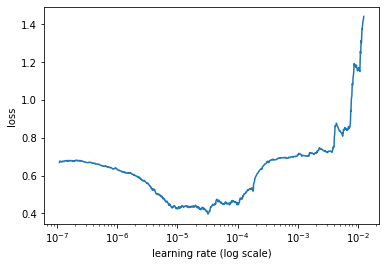

In [ ]:
learner.lr_plot()

In [ ]:
learner.autofit(1e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-05...
Train on 6090 samples, validate on 1523 samples
Epoch 1/1024
6090/6090 [==============================] - 197s 32ms/sample - loss: 0.4746 - acc: 0.7762 - val_loss: 0.3762 - val_acc: 0.8437
Epoch 2/1024
6090/6090 [==============================] - 194s 32ms/sample - loss: 0.3486 - acc: 0.8606 - val_loss: 0.3877 - val_acc: 0.8365
Epoch 3/1024
6080/6090 [============================>.] - ETA: 0s - loss: 0.2893 - acc: 0.8911
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-06 (if not early_stopping).
6090/6090 [==============================] - 194s 32ms/sample - loss: 0.2893 - acc: 0.8911 - val_loss: 0.4001 - val_acc: 0.8365
Epoch 4/1024
6090/6090 [==============================] - 194s 32ms/sample - loss: 0.2243 - acc: 0.9192 - val_loss: 0.4530 - val_acc: 0.8345
Epoch 5/1024
6080/6090 [=======

In [ ]:
learner.validate(val_data=(x_val_bert, y_val_bert), class_names=['No Disaster', 'Disaster'])

              precision    recall  f1-score   support

 No Disaster       0.84      0.90      0.87       869
    Disaster       0.85      0.77      0.81       654

    accuracy                           0.84      1523
   macro avg       0.85      0.83      0.84      1523
weighted avg       0.84      0.84      0.84      1523



array([[781,  88],
       [150, 504]])

### Getting predictor variable

In [ ]:
# getting predictor variable
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
learner.print_layers()

0 (trainable=True) : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f96453f4a50>
1 (trainable=True) : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9645b72c50>
2 (trainable=True) : <keras_bert.layers.embedding.TokenEmbedding object at 0x7f96453f4990>
3 (trainable=True) : <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f964539d390>
4 (trainable=True) : <tensorflow.python.keras.layers.merge.Add object at 0x7f96461ed550>
5 (trainable=True) : <keras_pos_embd.pos_embd.PositionEmbedding object at 0x7f96453bd090>
6 (trainable=True) : <tensorflow.python.keras.layers.core.Dropout object at 0x7f9645369c10>
7 (trainable=True) : <keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7f9644a232d0>
8 (trainable=True) : <keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x7f9644a1e3d0>
9 (trainable=True) : <tensorflow.python.keras.layers.core.Dropout object at 0x7f96449d1b50>
10 (trainable=True) : <t

### Getting predictions on test data

In [ ]:
test_df = pd.read_csv("test.csv")
test_df["target"] = predictor.predict(test_df["text"].tolist())

test_df = test_df[["id", "target"]]

In [ ]:
test_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
test_df.to_csv("output.csv", index=False)

In [ ]:
import os
os.getcwd()

'/content'

**Conclusion**:
1. Accuracy for machine
2.
3.